# Treinamento de Algoritmos para Subistituir o RocketCEA
O grande problema do RocketCEA é o seu tempo de execução. Para isso, este notebook propõe o treinamento de algoritmos de regressão para predição de valores calculados pelo CEA

In [16]:
# Importação de pacotes

from rocketcea.cea_obj_w_units import CEA_Obj
from proptools import nozzle  
import numpy as np
from itertools import product

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import os
import multiprocessing
import pandas as pd

from cea_function import calculate_cea_outputs

import joblib
import matplotlib.pyplot as plt



## Intervalo de operação dos atributos

- P_c (Pressure Chamber): 1e6 a 30e6;
- MR (Mixture Ratio): 1 a 9;
- eps (Expansion Ratio): 2 a 200.

In [17]:
def grid_search(N, grid_resolution):
    #N = 10  # Number of parameters
    #grid_resolution = 3  # Granularity of the grid

    param_ranges = [np.linspace(0, 1, grid_resolution) for _ in range(N)]
    grid_points = np.array(list(product(*param_ranges)))

    return grid_points


grid_points = grid_search(N=3, grid_resolution=30)
grid_points.shape   

(27000, 3)

In [3]:
# Processamento paralelo
bound_values = np.array([[1e6, 30e6], [1, 9], [2, 200]])

def calculate_cea_params_single(params):
    oxName='LOX'
    fuelName='RP-1'
    ceaObj = CEA_Obj( oxName=oxName, fuelName=fuelName, pressure_units='MPa', cstar_units='m/s', temperature_units='K')

    #min_mat = bound_values.T[0, :]
    #max_mat = bound_values.T[1,:]
    #denorm_values = params * (max_mat - min_mat) + min_mat
    
    #IspVac, Cstar, Tc, mw, gamma = ceaObj.get_IvacCstrTc_ChmMwGam(Pc=params[0], MR=params[1], eps=params[2])
    #valores_calculados = [IspVac, Cstar, Tc, gamma]
    valores_calculados = params
    print(params)
    return valores_calculados


def calc_fitness(params_matrix, bound_values, fitness_func, parallel=True):
    min_mat = bound_values.T[0, :]
    max_mat = bound_values.T[1,:]
    denorm_matrix = params_matrix * (max_mat - min_mat) + min_mat

    if parallel:
        num_workers = os.cpu_count()
    else:
        num_workers = 1

    pool = multiprocessing.Pool(processes=num_workers)
    results = pool.map(fitness_func, denorm_matrix)
    pool.close()
    pool.join()
    results = np.array(results)
    #print(denorm_matrix)

    return results



class CalculaCEA():
    def __init__(self, bound_values, parallel=True):
        self.bound_values = bound_values

        self.min_mat = bound_values.T[0, :]
        self.max_mat = bound_values.T[1,:]

        if parallel:
            self.num_workers = os.cpu_count()
        else:
            self.num_workers = 1


    def calculate_cea_single(self, params):
        oxName='LOX'
        fuelName='RP-1'
        self.ceaObj = CEA_Obj( oxName=oxName, fuelName=fuelName, pressure_units='MPa', cstar_units='m/s', temperature_units='K')
        IspVac, Cstar, Tc, mw, gamma = self.ceaObj.get_IvacCstrTc_ChmMwGam(Pc=params[0], MR=params[1], eps=params[2])

        valores_calculados = [IspVac, Cstar, Tc, mw, gamma]
        return valores_calculados

    
    def calc_fitness(self, params_matrix):
        denorm_matrix = params_matrix * (self.max_mat - self.min_mat) + self.min_mat
        pool = multiprocessing.Pool(processes=self.num_workers)
        results = pool.map(calculate_cea_outputs, denorm_matrix)
        pool.close()
        pool.join()
        results = np.array(results)
        return results



cea_fitness = CalculaCEA(bound_values, parallel=True)
#y = calc_fitness(grid_points, bound_values, calculate_cea_params_single, parallel=True)
y = cea_fitness.calc_fitness(grid_points)

In [4]:
y

array([[1.61337298e+02, 1.86441717e+02, 1.23094942e+03, 4.22234735e+01,
        2.61820282e+03, 8.80964731e-01],
       [1.63474233e+02, 2.13683072e+02, 1.23094942e+03, 4.22234735e+01,
        2.61820282e+03, 8.80964731e-01],
       [1.52173751e+02, 2.27487009e+02, 1.23094942e+03, 4.22234735e+01,
        2.61820282e+03, 8.80964731e-01],
       ...,
       [2.24782489e+02, 2.79561155e+02, 1.38762554e+03, 3.25401168e+01,
        3.01099485e+03, 1.10225318e+00],
       [2.28255040e+02, 2.79627100e+02, 1.38762554e+03, 3.25401168e+01,
        3.01099485e+03, 1.10225318e+00],
       [2.28264994e+02, 2.79692165e+02, 1.38762554e+03, 3.25401168e+01,
        3.01099485e+03, 1.10225318e+00]])

In [5]:
df_grid_points = pd.DataFrame(grid_points, columns=['P_c', 'MR', 'eps'])
df_target = pd.DataFrame(y, columns=['IspSea','IspVac','Cstar', 'Tc', 'mw', 'gamma', ])
df_grid_target = pd.concat([df_grid_points, df_target], axis=1)
df_grid_target.to_csv('grid_target.csv', index=False)


In [6]:
# Le o arquivo carregado com o grid e o target
df_grid_target = pd.read_csv('grid_target.csv')

# Processa e converte para numpy
X_y = df_grid_target.to_numpy()
X = X_y[:,0:3]
y = X_y[:,3:]

# Deleta o dataframe para liberar espaco na RAM
del df_grid_target

In [7]:
# Separa dos dados em treino, validação e teste
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=0)

# Regressão Linear

In [16]:
reg = LinearRegression().fit(X_train, y_train)
pred = reg.predict(X_test)
reg.score(X_test, y_test)


0.36824962413240636

In [17]:
for i in range(10):
    print(pred[i][0], y_test[i][0])

227.38585781246243 260.11616122208034
249.29631929573674 269.25776795616883
221.7940362152894 255.2759537871661
241.11579707456806 268.4571309742733
287.9705010918276 281.2518575195008
222.37866198411294 229.11064501790196
234.7693931873497 265.04686285478385
226.207850505418 235.87251101014888
254.10374516561197 240.1425011501275
256.0760450980834 292.54623529375294


# MLP

In [124]:
regr = MLPRegressor(random_state=1, 
                    max_iter=1000,
                    hidden_layer_sizes=(256,) 
                    ).fit(X_train, y_train)

/opt/homebrew/anaconda3/envs/deeplearning/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [126]:
pred = regr.predict(X_test)
regr.score(X_test, y_test)


0.9625170772180227

In [127]:
for i in range(20):
    print(pred[i][0], y_test[i][0])

361.2134073948461 354.67898701087415
395.46987001951385 391.9493564111563
335.58194175658605 341.22386541453875
271.24388191947713 274.2840269077994
354.8419259371778 344.26409197079647
338.49627196864407 334.1771512879666
333.5691309815153 331.7665612415897
337.4862391179062 331.70429568246385
301.22382744235034 301.3335244947692
286.7441482525414 277.2463072131506
352.60754340120394 354.54763150793275
313.5247257551567 312.88618961940887
349.4336376360856 346.7379025088469
332.8563507904534 327.8366164319221
391.16864550974526 389.27560552234524
294.51626031841505 289.04610051648524
313.44782035669505 314.6381659765613
276.2392448005391 283.6709941799367
374.8724389257979 367.900631538755
395.05979035022335 387.4002962851506


In [130]:
import time

start_time = time.time()

for i in range(10000):
    time.sleep(1/10000)
    regr.predict(X_test[0:1])

end_time = time.time()
execution_time =  end_time - start_time
print("Execution time:",execution_time)


Execution time: 1.5532879829406738


# Random Forest Regression

In [136]:
reg_forest = RandomForestRegressor(max_depth=100, random_state=0)
reg_forest.fit(X_train, y_train)

RandomForestRegressor(max_depth=100, random_state=0)

In [137]:
pred = reg_forest.predict(X_test)
reg_forest.score(X_test, y_test)


0.9992907412722483

In [138]:
for i in range(20):
    print(pred[i][0], y_test[i][0])

354.7267981601076 354.67898701087415
391.4950448443861 391.9493564111563
341.04457459140787 341.22386541453875
274.2136578167049 274.2840269077994
344.1644003918606 344.26409197079647
333.7144138915461 334.1771512879666
331.6685933981436 331.7665612415897
331.4333924700347 331.70429568246385
300.95183796535963 301.3335244947692
277.6112833032955 277.2463072131506
354.55933323153397 354.54763150793275
312.6985969650189 312.88618961940887
346.5371755332889 346.7379025088469
328.062021675771 327.8366164319221
388.93769138452785 389.27560552234524
288.95857673287594 289.04610051648524
314.79187604142163 314.6381659765613
283.1144836044798 283.6709941799367
367.9804160691997 367.900631538755
387.8011496659244 387.4002962851506


In [139]:
import time

start_time = time.time()

for i in range(10000):
    #time.sleep(1/10000)
    reg_forest.predict(X_test[0:1])

end_time = time.time()
execution_time =  end_time - start_time
print("Execution time:",execution_time)


Execution time: 19.11455488204956


# Decision Tree Regression

In [8]:
reg_tree = DecisionTreeRegressor(max_depth=1000)
reg_tree.fit(X_train, y_train)


DecisionTreeRegressor(max_depth=1000)

In [9]:
pred = reg_tree.predict(X_test)
reg_tree.score(X_test, y_test)


0.9988825161236132

In [10]:
import time

start_time = time.time()

for i in range(10000):
    #time.sleep(1/10000)
    reg_tree.predict(X_test[0:1])

end_time = time.time()
execution_time =  end_time - start_time
print("Execution time:",execution_time)


Execution time: 0.20331692695617676


In [11]:
for i in range(100):
    print(pred[i][0], y_test[i][0])

258.2546210843896 260.11616122208034
269.6670900842741 269.25776795616883
255.2706758023976 255.2759537871661
267.8193244199776 268.4571309742733
281.3096809493365 281.2518575195008
229.13817019957517 229.11064501790196
267.09537433126906 265.04686285478385
235.8810296665839 235.87251101014888
240.5040301623573 240.1425011501275
292.21579491312286 292.54623529375294
227.56586163296552 227.56777051362425
228.91935195387563 234.18245052596708
267.33151896176537 267.2118277731915
263.00143303423107 260.9174137107724
290.99015692976445 291.80729254769426
276.2804169730872 273.9446216643261
230.26757262762763 230.24007743833727
323.2581968505908 322.48691784434305
59.521677590432034 59.59472817071542
245.34635457805288 245.33435288779893
124.41796447700658 123.98191610555898
283.4455894483758 283.0984447388558
224.0314872473444 225.31728126576417
263.9336205790644 263.6152478264797
221.82524158338404 221.7718132956611
221.0477250521714 221.43850237025893
265.0406622549181 266.2777558203033


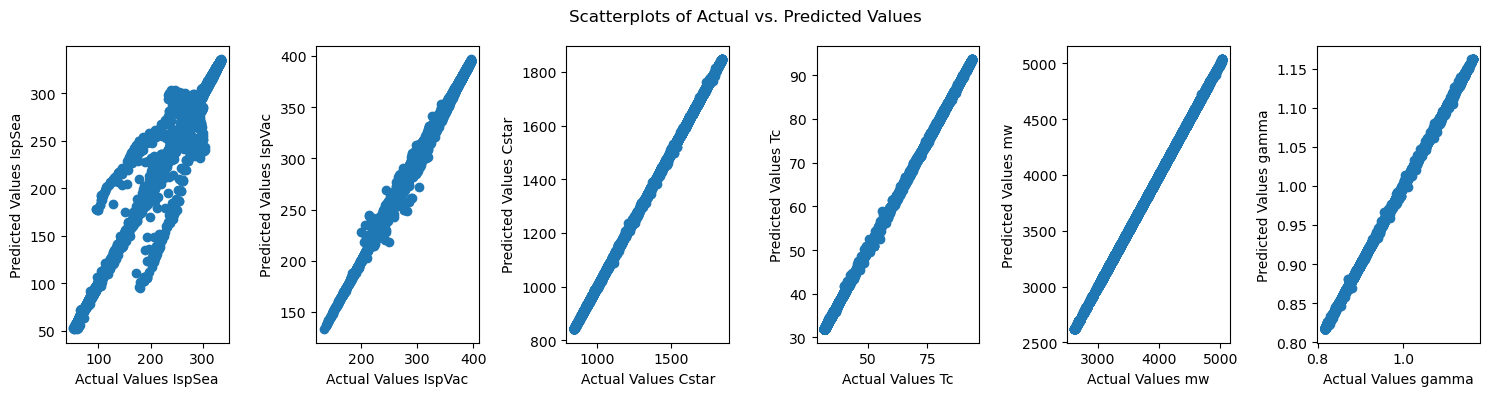

In [14]:
# Número de subplots

num_plots = 6

# Configuração da figura
fig, axes = plt.subplots(1, num_plots, figsize=(15, 4))  # 1 linha e 'num_plots' colunas de subplots.

# Título geral
fig.suptitle("Scatterplots of Actual vs. Predicted Values")

nomes_predicoes = ['IspSea', 'IspVac', 'Cstar', 'Tc', 'mw', 'gamma']

# Loop para criar os subplots
for i in range(num_plots):
    ax = axes[i]
    ax.scatter(y_test[:, i], pred[:, i])
    ax.set_xlabel(f"Actual Values {nomes_predicoes[i]}")
    ax.set_ylabel(f"Predicted Values {nomes_predicoes[i]}")

plt.tight_layout()
plt.show()

In [15]:
# Salva o modelo
joblib.dump(reg_tree, 'decision_tree_model.pkl')


['decision_tree_model.pkl']

In [37]:
model = joblib.load('/Users/pdcos/Documents/Estudos/Mestrado/Tese/Implementação da Tese do Jentzsch/rocket_optimization_implementation/model/engines/decision_tree_model.pkl')

In [38]:
model

DecisionTreeRegressor(max_depth=1000)